Note: nbdev ignores notebooks that have a name starting with underscore

In [ ]:
from decision_tree.imports import *
from decision_tree.core import *
from decision_tree.data import *
from decision_tree.models import *

import time
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual
import ipywidgets as widgets
from IPython.display import display

# Interactive Tree Ensemble Demo

> Show how we can use jupyter widgets to try different hyper parameters

## How to use

Load data copied from the final model used in https://github.com/fastai/fastai/tree/master/courses/ml1/lesson2-rf_interpretation.ipynb

In [ ]:
bulldozers_data = np.load('test/data/bulldozers.npy', allow_pickle=True)
train_data = DataWrapper(*bulldozers_data[:4])
valid_data = DataWrapper(*bulldozers_data[4:])
train_data, valid_data

(DataWrapper(x:['YearMade' 'Coupler_System' 'ProductSize' 'fiProductClassDesc' 'ModelID'
  'saleElapsed' 'fiSecondaryDesc' 'fiModelDesc' 'Enclosure'
  'fiModelDescriptor' 'Hydraulics_Flow' 'Drive_System' 'ProductGroup'
  'Track_Type' 'state' 'saleDay' 'ProductGroupDesc' 'age'] y:SalePrice, len:389125),
 DataWrapper(x:['YearMade' 'Coupler_System' 'ProductSize' 'fiProductClassDesc' 'ModelID'
  'saleElapsed' 'fiSecondaryDesc' 'fiModelDesc' 'Enclosure'
  'fiModelDescriptor' 'Hydraulics_Flow' 'Drive_System' 'ProductGroup'
  'Track_Type' 'state' 'saleDay' 'ProductGroupDesc' 'age'] y:SalePrice, len:12000))

Set-up vars to track the best model we have so far and a history of everything we try

In [ ]:
best, history = [np.inf, None], []

Set-up the function that we will interact with. This function will;
- build a `TreeEnsemble`
- fit it
- calculate validation loss using RMSE (of `log(SalePrice)`)
- plot preds vs actuals
- print details of hypers we're using, how long things took etc
- save `[loss, m, durations]` to `best` if we have found a lower loss
- save `[loss, m, durations]` to `history` for everything we try

In [ ]:
def to_durations(ts):
    "convert a list of n times in seconds to n-1 durations"
    return [ts[i+1]-ts[i] for i in range(len(ts)-1)]

def time_fit(n_rows, sample_size=1500, min_leaf_samples=5, n_trees=10):
    print('sample_size*n_trees', sample_size*n_trees)
    global best
    t0 = time.time()
    data = train_data.tail(int(n_rows))
    t1 = time.time()
    sample_size = sample_size=int(n_rows*sample_size) if sample_size<1 else int(sample_size)
    m = TreeEnsemble(data, sample_size=sample_size, min_leaf_samples=min_leaf_samples, n_trees=n_trees)
    t2 = time.time()
    %time m.fit()
    t3 = time.time()
    durations = to_durations([t0,t1,t2,t3])
    print('\n', m, '\n', durations, '\n')
    test_preds = m.predict(valid_data.x)
    loss = rmse(test_preds, valid_data.y)
    history.append([loss, m, durations])
    if loss < best[0]: 
        print('loss', loss, '<- this is a new best', 'previous best', best[0])
        best = [loss, m, durations]
    else:
        print('loss', loss, 'previous best', best[0])
    plt.scatter(test_preds, valid_data.y, alpha=.1);

https://github.com/fastai/fastai/blob/master/courses/ml1/lesson2-rf_interpretation.ipynb got a validation RMSE 0.2109679613161783 using `RandomForestRegressor(n_estimators=160, max_features=0.5, n_jobs=-1, oob_score=True)`

In [ ]:
interact_manual(time_fit, 
    n_rows=widgets.IntSlider(min=1000, max=train_data.x_rows, step=1000, value=1000),
    sample_size=widgets.IntSlider(min=100, max=train_data.x_rows/10, step=100, value=500),
    min_leaf_samples=widgets.IntSlider(min=1, max=10, step=1, value=5),
    n_trees=widgets.IntSlider(min=1, max=160, step=1, value=15));

interactive(children=(IntSlider(value=1000, description='n_rows', max=389125, min=1000, step=1000), IntSlider(…

The next bit sets up some buttons so that we can interact with the history etc

In [ ]:
show_best_button = widgets.Button(description="Show Best")
show_last_button = widgets.Button(description="Show Last")
save_hist_button = widgets.Button(description="Save History")
load_hist_button = widgets.Button(description="Load History")
button_box = widgets.HBox([show_best_button, show_last_button, save_hist_button, load_hist_button])
output = widgets.Output()
display(button_box, output)

def show_best_button_button_clicked(b):
    with output: output.clear_output(); print('Best\n', best)
show_best_button.on_click(show_best_button_button_clicked)

def show_last_button_button_clicked(b):
    with output: output.clear_output(); print('Last\n', history[-1])
show_last_button.on_click(show_last_button_button_clicked)

def save_hist_button_button_clicked(b):
    filename='tmp_history'
    with output: 
        output.clear_output(); print(f'Saving history to {filename}.npy')
        np.save(filename, history)
        print('Saved')
save_hist_button.on_click(save_hist_button_button_clicked)

def load_hist_button_button_clicked(b):
    global history
    filename='tmp_history.npy'
    with output:
        output.clear_output(); print(f'Loadinging history from {filename}')
        try: 
            history = np.load(filename, allow_pickle=True)
            print('Loaded')
        except FileNotFoundError: 
            print('Not loaded. No saved history found')
load_hist_button.on_click(load_hist_button_button_clicked)

Output()

## You can run `time_fit` without interact too

sample_size*n_trees 1000.0
CPU times: user 32.6 ms, sys: 56.4 ms, total: 89 ms
Wall time: 119 ms

 tEnsemble(data=DataWrapper(x:['YearMade' 'Coupler_System' 'ProductSize' 'fiProductClassDesc' 'ModelID'
 'saleElapsed' 'fiSecondaryDesc' 'fiModelDesc' 'Enclosure'
 'fiModelDescriptor' 'Hydraulics_Flow' 'Drive_System' 'ProductGroup'
 'Track_Type' 'state' 'saleDay' 'ProductGroupDesc' 'age'] y:SalePrice, len:1000) n_trees=10 sample_size=100 max_depth=None min_leaf_samples=5) 
 [2.7894973754882812e-05, 0.0013260841369628906, 0.11892843246459961] 

loss 0.7403458542757663 previous best 0.6672753328045001


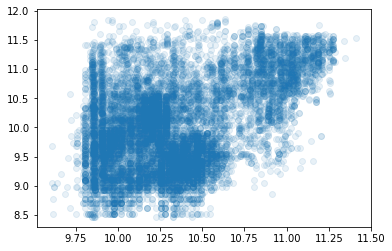

In [ ]:
time_fit(1e3, 1e2)